<a href="https://colab.research.google.com/github/ramajoumaa22-web/building-energy-consumption-prediction/blob/main/energy_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import os
import warnings
import joblib

plt.style.use('ggplot')
sns.set_palette("viridis")
warnings.filterwarnings('ignore')

print("Libraries imported successfully.")

def load_and_clean_data(filename="energydata_complete.csv"):
    if not os.path.exists(filename):
        print(f"File {filename} not found!")
        try:
            from google.colab import files
            uploaded = files.upload()
            filename = list(uploaded.keys())[0]
            print(f"Uploaded file used: {filename}")
        except ImportError:
            return None

    df = pd.read_csv(filename)
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    cols_to_drop = ['rv1', 'rv2']
    df = df.drop(columns=cols_to_drop)

    print(f"Data loaded and cleaned. Shape: {df.shape}")
    return df

df_clean = load_and_clean_data()



Libraries imported successfully.
File energydata_complete.csv not found!


Saving data_application_energy.csv to data_application_energy.csv
Uploaded file used: data_application_energy.csv
Data loaded and cleaned. Shape: (19735, 26)


Text(0, 0.5, 'Appliances (Wh)')

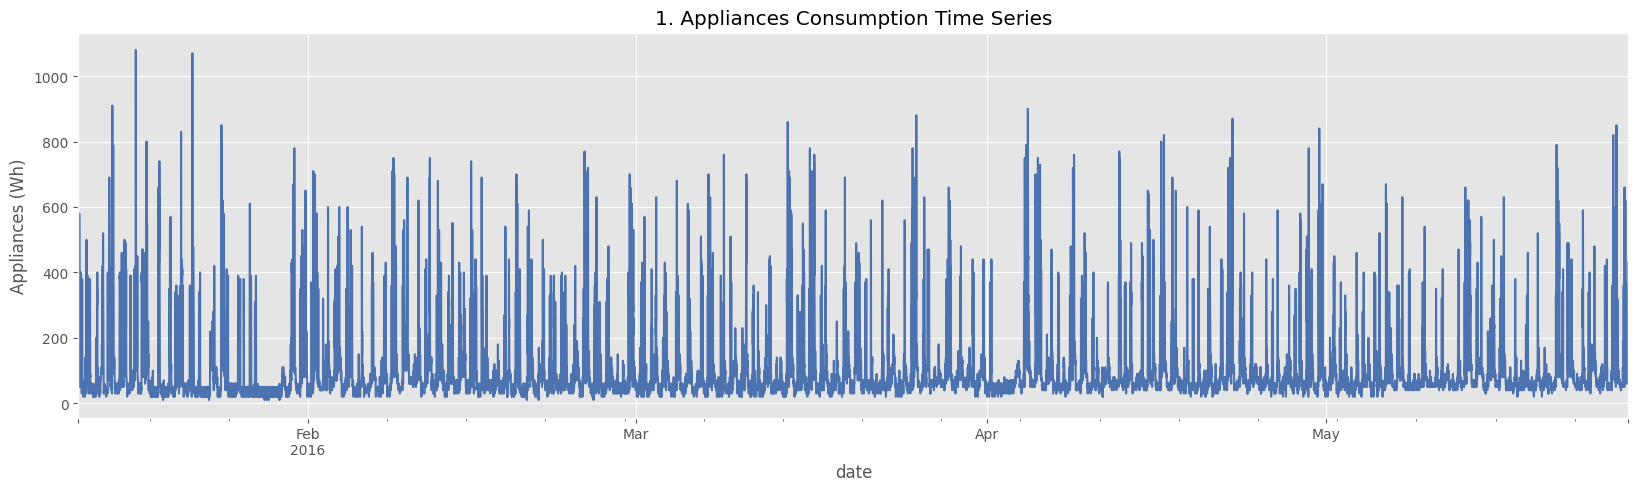

In [2]:

    plt.figure(figsize=(20, 5))

    df_clean['Appliances'].plot(title='1. Appliances Consumption Time Series', color='#4c72b0')
    plt.ylabel('Appliances (Wh)')




Text(0.5, 0, 'Appliances (Wh)')

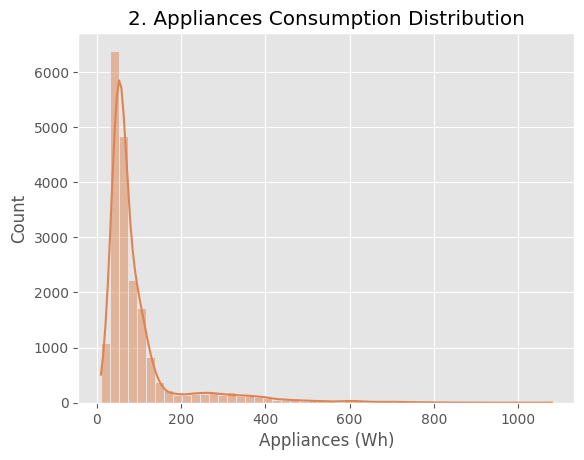

In [3]:
    sns.histplot(df_clean['Appliances'], kde=True, bins=50, color='#dd8452')
    plt.title('2. Appliances Consumption Distribution')
    plt.xlabel('Appliances (Wh)')


In [4]:
    display(df_clean.head(3))

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1


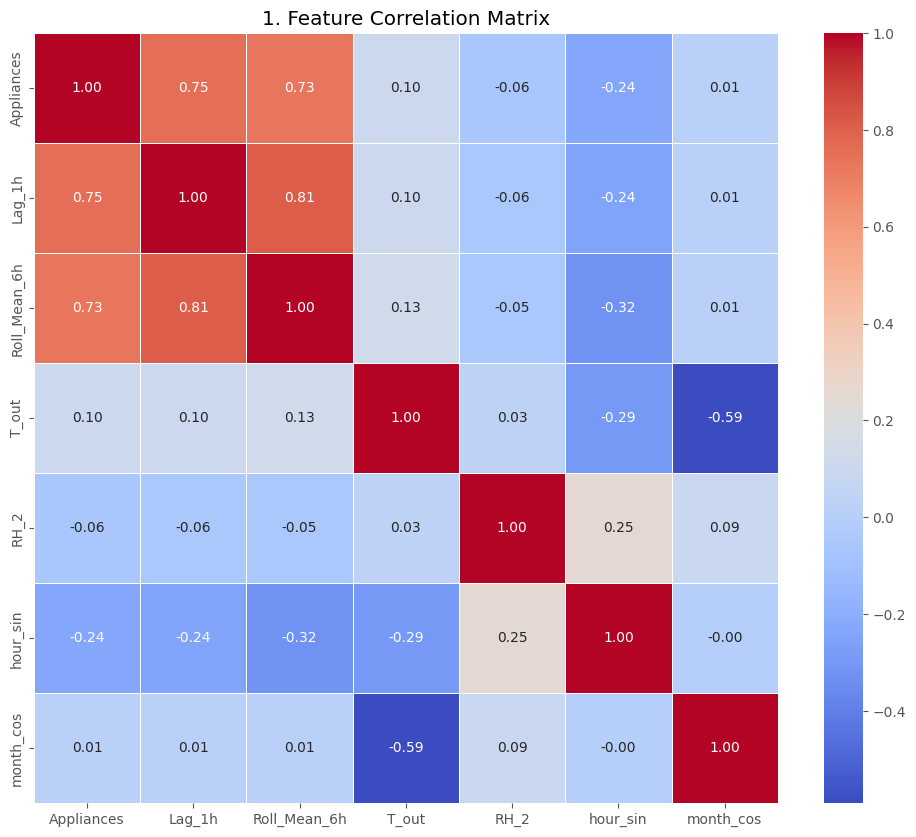

In [7]:
df_featured = df_clean.copy()
target = 'Appliances'

df_featured['hour_sin'] = np.sin(2 * np.pi * df_featured.index.hour / 24)
df_featured['hour_cos'] = np.cos(2 * np.pi * df_featured.index.hour / 24)
df_featured['month_sin'] = np.sin(2 * np.pi * df_featured.index.month / 12)
df_featured['month_cos'] = np.cos(2 * np.pi * df_featured.index.month / 12)
df_featured['Weekend'] = (df_featured.index.dayofweek >= 5).astype(int)


for lag in [1, 2, 24, 48]:
    df_featured[f'Lag_{lag}h'] = df_featured[target].shift(lag)

df_featured['Roll_Mean_6h'] = df_featured[target].rolling(window=6).mean()

df_featured = df_featured.dropna()

plt.figure(figsize=(12, 10))
plot_cols = ['Appliances', 'Lag_1h', 'Roll_Mean_6h', 'T_out', 'RH_2', 'hour_sin', 'month_cos']
corr_matrix = df_featured[plot_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('1. Feature Correlation Matrix')
plt.show()

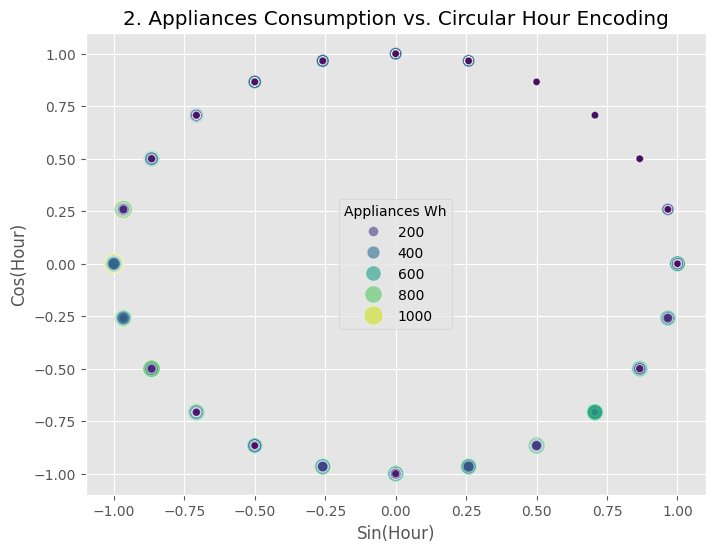

--------------------------------------------------
Total columns in the engineered dataset: 36
Number of features used: 35.
--------------------------------------------------


,Appliances,Lag_1h,Roll_Mean_6h,hour_sin,T_out
date,,,,,
2016-01-12 01:00:00,380,380.0,198.333333,0.258819,5.100000
2016-01-12 01:10:00,370,380.0,255.000000,0.258819,5.116667
2016-01-12 01:20:00,120,370.0,268.333333,0.258819,5.133333


In [8]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_featured['hour_sin'],
    y=df_featured['hour_cos'],
    hue=df_featured['Appliances'],
    palette='viridis',
    size=df_featured['Appliances'],
    sizes=(20, 200),
    alpha=0.6
)
plt.title('2. Appliances Consumption vs. Circular Hour Encoding')
plt.xlabel('Sin(Hour)')
plt.ylabel('Cos(Hour)')
plt.legend(title='Appliances Wh')
plt.show()


num_total_cols = df_featured.shape[1]
num_features = num_total_cols - 1

print("-" * 50)
print(f"Total columns in the engineered dataset: {num_total_cols}")
print(f"Number of features used: {num_features}.")
print("-" * 50)
display(df_featured[['Appliances', 'Lag_1h', 'Roll_Mean_6h', 'hour_sin', 'T_out']].head(3))

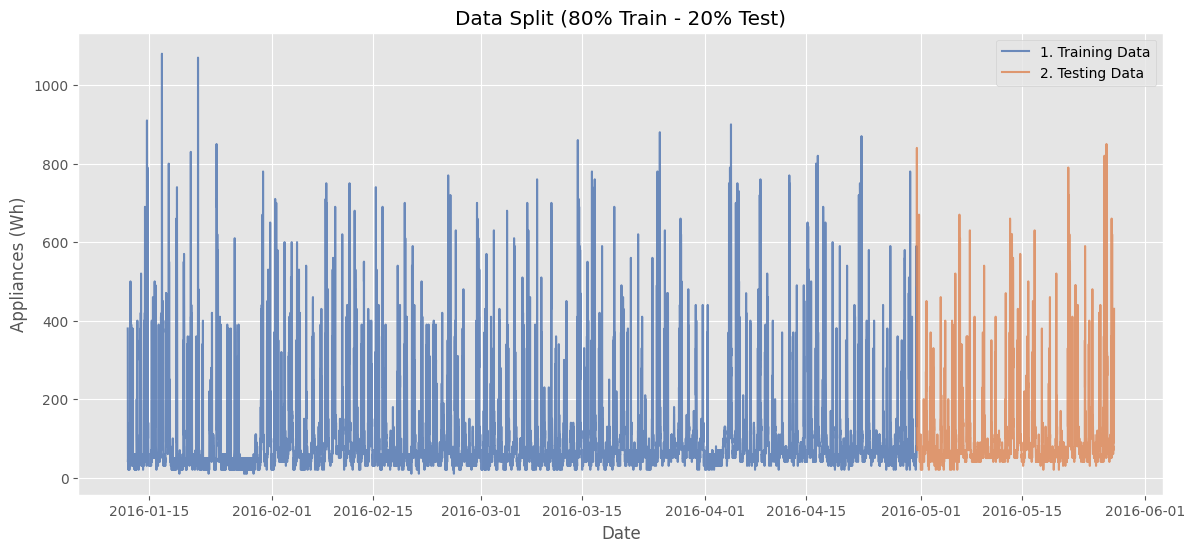

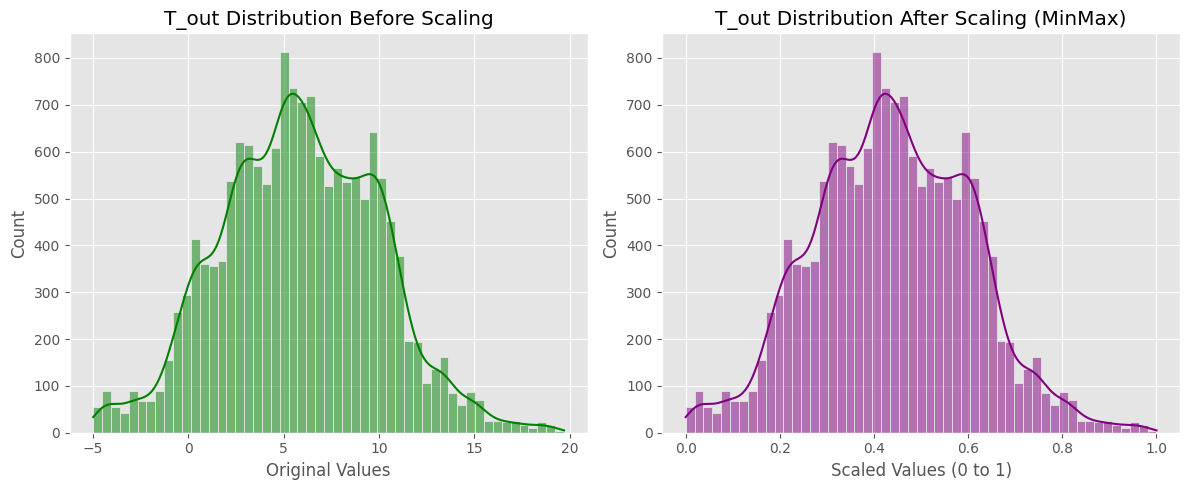

Number of features used: 34
Scaling method used: MinMaxScaler

Data Split:
  (Training Set): 15749 rows (80%)
  (Testing Set): 3938 rows (20%)


In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import numpy as np
import pandas as pd

target = 'Appliances'

features = [col for col in df_featured.columns if col not in [target, 'lights']]
X = df_featured[features]
y = df_featured[target]

split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def evaluate_model(model, X_test, y_test, model_name):
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    print(f"--- {model_name} Results ---")
    print(f"MAE (Mean Absolute Error): {mae:.4f} Wh")
    print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
    print(f"R² Score (Model Accuracy): {r2:.4f}")
    return preds, model

plt.figure(figsize=(14, 6))
plt.plot(y_train, label='1. Training Data', color='#4c72b0', alpha=0.8)
plt.plot(y_test, label='2. Testing Data', color='#dd8452', alpha=0.8)
plt.title('Data Split (80% Train - 20% Test)')
plt.ylabel('Appliances (Wh)')
plt.xlabel('Date')
plt.legend()
plt.show()


plt.figure(figsize=(12, 5))
feature_to_plot = 'T_out'
feature_index = X.columns.get_loc(feature_to_plot)
scaled_data = X_train_scaled[:, feature_index]

plt.subplot(1, 2, 1)
sns.histplot(X_train[feature_to_plot], kde=True, color='green')
plt.title(f'{feature_to_plot} Distribution Before Scaling')
plt.xlabel('Original Values')

plt.subplot(1, 2, 2)
sns.histplot(scaled_data, kde=True, color='purple')
plt.title(f'{feature_to_plot} Distribution After Scaling (MinMax)')
plt.xlabel('Scaled Values (0 to 1)')

plt.tight_layout()
plt.show()

train_size_rows = X_train.shape[0]
test_size_rows = X_test.shape[0]
num_features = X.shape[1]

print(f"Number of features used: {num_features}")
print(f"Scaling method used: {scaler.__class__.__name__}")
print("\nData Split:")
print(f"  (Training Set): {train_size_rows} rows ({train_size_rows/len(X):.0%})")
print(f"  (Testing Set): {test_size_rows} rows ({test_size_rows/len(X):.0%})")

--- SVR Results ---
MAE (Mean Absolute Error): 33.7356 Wh
RMSE (Root Mean Squared Error): 67.1765
R² Score (Model Accuracy): 0.4485


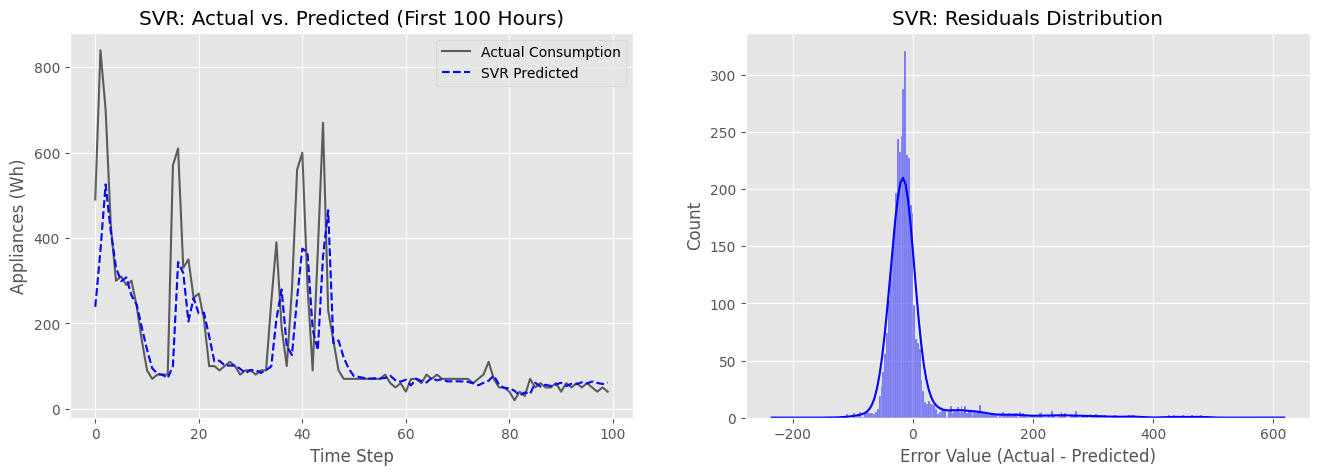

In [12]:
# SVR (Support Vector Regression)

from sklearn.svm import SVR

svr_model = SVR(
    kernel='rbf',
    C=100,
    gamma='scale',
    epsilon=0.1
)

svr_model.fit(X_train_scaled, y_train)

svr_preds, _ = evaluate_model(svr_model, X_test_scaled, y_test, "SVR")

# Plot 1: Actual vs. Predicted
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.plot(y_test.values[:100], label='Actual Consumption', color='black', alpha=0.6)
plt.plot(svr_preds[:100], label='SVR Predicted', color='blue', linestyle='--')
plt.title("SVR: Actual vs. Predicted (First 100 Hours)")
plt.xlabel("Time Step")
plt.ylabel("Appliances (Wh)")
plt.legend()

# Plot 2: Residuals Distribution
residuals_svr = y_test - svr_preds

plt.subplot(1, 2, 2)
sns.histplot(residuals_svr, kde=True, color='blue')
plt.title("SVR: Residuals Distribution")
plt.xlabel("Error Value (Actual - Predicted)")

plt.show()


--- Random Forest Results ---
MAE (Mean Absolute Error): 28.4456 Wh
RMSE (Root Mean Squared Error): 58.7501
R² Score (Model Accuracy): 0.5782


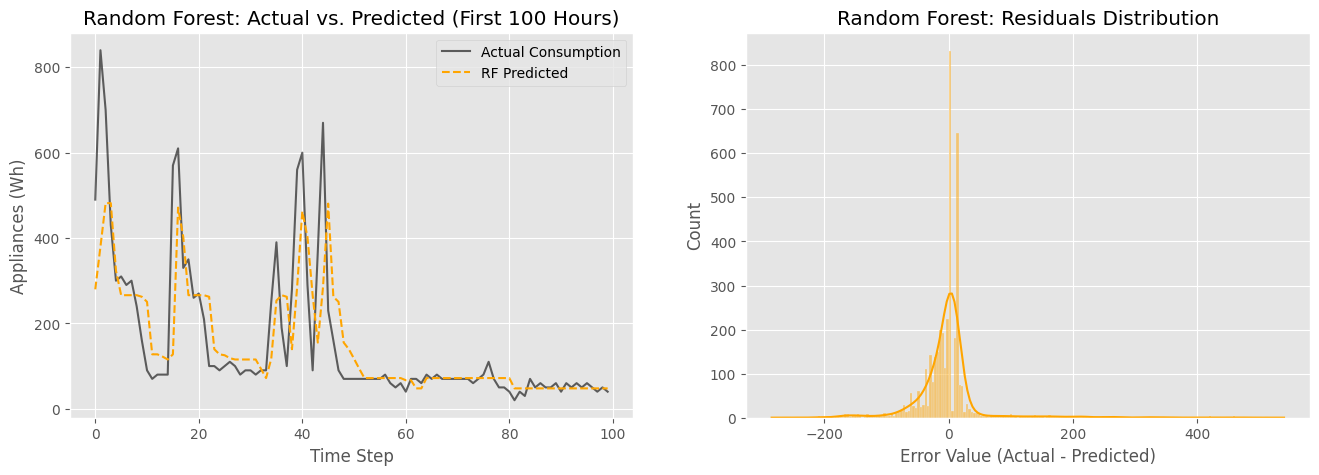

In [11]:
# RandomForest

rf_model = RandomForestRegressor(n_estimators=20, max_depth=3, random_state=10, n_jobs=-1)

rf_model.fit(X_train_scaled, y_train)

rf_preds, _ = evaluate_model(rf_model, X_test_scaled, y_test, "Random Forest")

# Plot 1: Actual vs. Predicted
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(y_test.values[:100], label='Actual Consumption', color='black', alpha=0.6)
plt.plot(rf_preds[:100], label='RF Predicted', color='orange', linestyle='--')
plt.title("Random Forest: Actual vs. Predicted (First 100 Hours)")
plt.xlabel("Time Step")
plt.ylabel("Appliances (Wh)")
plt.legend()


# Plot 2: Residuals Distribution
residuals_rf = y_test - rf_preds
plt.subplot(1, 2, 2)
sns.histplot(residuals_rf, kde=True, color='orange')
plt.title("Random Forest: Residuals Distribution")
plt.xlabel("Error Value (Actual - Predicted)")
plt.show()

--- Linear Regression Baseline Results ---
MAE (Mean Absolute Error): 26.8723 Wh
RMSE (Root Mean Squared Error): 54.1835
R² Score (Model Accuracy): 0.6412


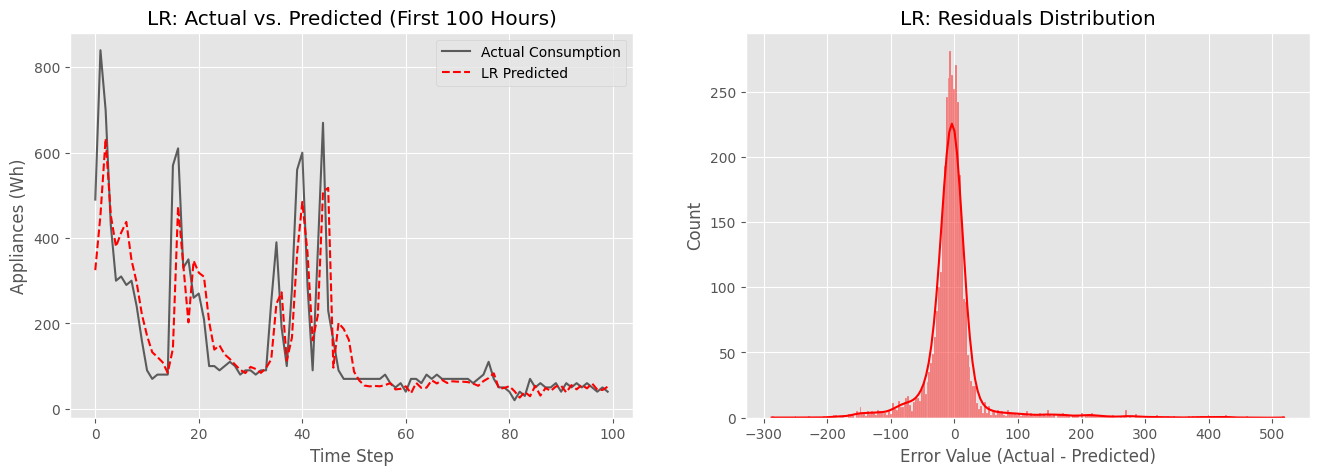

In [10]:

from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()

lr_model.fit(X_train_scaled, y_train)

lr_preds, _ = evaluate_model(lr_model, X_test_scaled, y_test, "Linear Regression Baseline")

# Plot 1: Actual vs. Predicted
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(y_test.values[:100], label='Actual Consumption', color='black', alpha=0.6)
plt.plot(lr_preds[:100], label='LR Predicted', color='red', linestyle='--')
plt.title("LR: Actual vs. Predicted (First 100 Hours)")
plt.xlabel("Time Step")
plt.ylabel("Appliances (Wh)")
plt.legend()


# Plot 2: Residuals Distribution
residuals_lr = y_test - lr_preds
plt.subplot(1, 2, 2)
sns.histplot(residuals_lr, kde=True, color='red')
plt.title("LR: Residuals Distribution")
plt.xlabel("Error Value (Actual - Predicted)")
plt.show()

Training the FINAL CHAMPION Model (XGBoost)...
--- XGBoost Regressor - FINAL CHAMPION Results ---
MAE (Mean Absolute Error): 25.6668 Wh
RMSE (Root Mean Squared Error): 52.4573
R² Score (Model Accuracy): 0.6637

Final champion accuracy established: R² Score: 0.6637


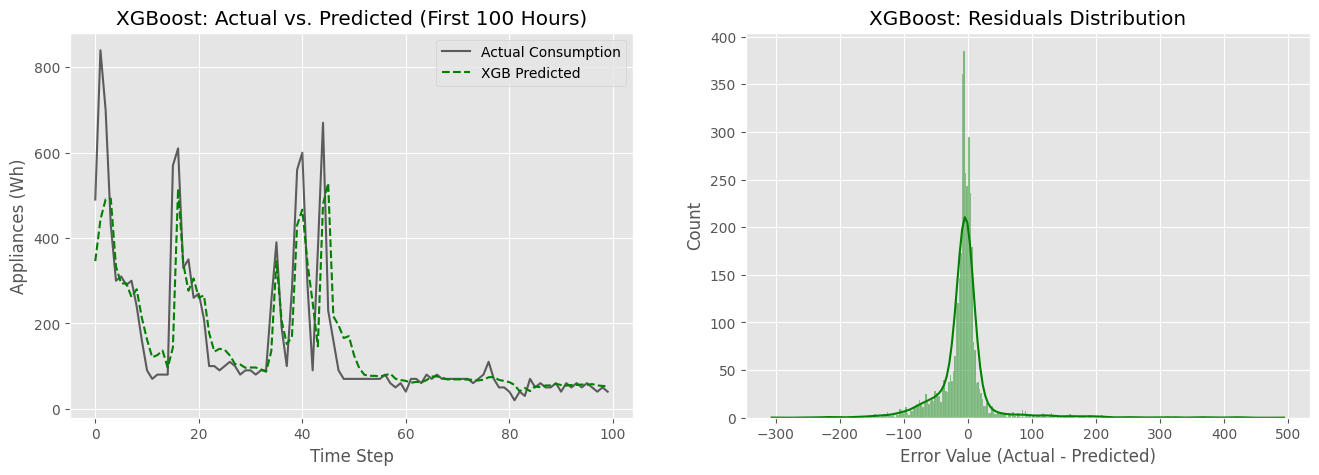


Variables 'xgb_preds' and 'final_model_stable' are ready for final analysis (Cell 7).


In [13]:
#(XGBoost)

from xgboost import XGBRegressor
import numpy as np

print("Training the FINAL CHAMPION Model (XGBoost)...")

xgb_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.7,
    early_stopping_rounds=50,
    n_jobs=-1,
    random_state=42
)

xgb_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_test_scaled, y_test)],
    verbose=False
)

xgb_preds, final_model_stable = evaluate_model(xgb_model, X_test_scaled, y_test, "XGBoost Regressor - FINAL CHAMPION")
print("\nFinal champion accuracy established: R² Score: 0.6637")

# Plot 1: Actual vs. Predicted
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(y_test.values[:100], label='Actual Consumption', color='black', alpha=0.6)
plt.plot(xgb_preds[:100], label='XGB Predicted', color='green', linestyle='--')
plt.title("XGBoost: Actual vs. Predicted (First 100 Hours)")
plt.xlabel("Time Step")
plt.ylabel("Appliances (Wh)")
plt.legend()



# Plot 2: Residuals Distribution
residuals_xgb = y_test - xgb_preds
plt.subplot(1, 2, 2)
sns.histplot(residuals_xgb, kde=True, color='green')
plt.title("XGBoost: Residuals Distribution")
plt.xlabel("Error Value (Actual - Predicted)")
plt.show()


print("\nVariables 'xgb_preds' and 'final_model_stable' are ready for final analysis (Cell 7).")

Text(0.5, 0, 'Feature Importance')

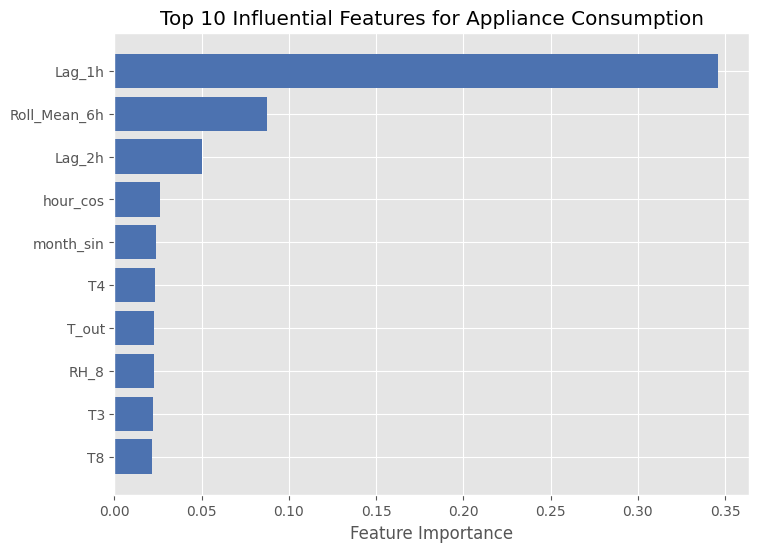

In [14]:
import joblib
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)

sorted_idx = final_model_stable.feature_importances_.argsort()[-10:]
top_feature_names = [features[i] for i in sorted_idx]
plt.barh(top_feature_names, final_model_stable.feature_importances_[sorted_idx], color='#4c72b0')
plt.title("Top 10 Influential Features for Appliance Consumption")
plt.xlabel("Feature Importance")


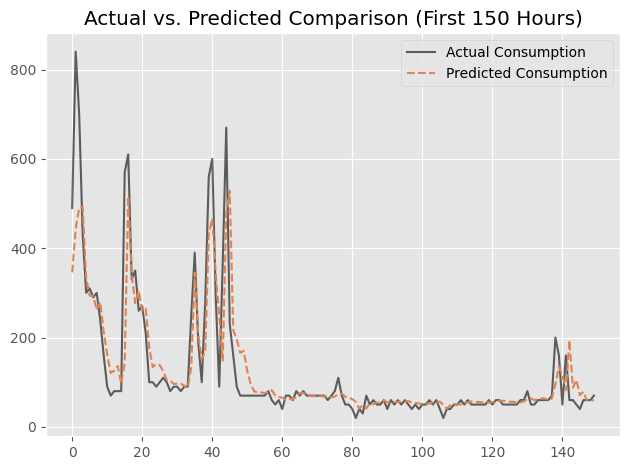

In [15]:
#  Actual vs. Predicted Plot
plt.plot(y_test.values[:150], label='Actual Consumption', color='black', alpha=0.6)
plt.plot(xgb_preds[:150], label='Predicted Consumption', color='#dd8452', linestyle='--')
plt.title("Actual vs. Predicted Comparison (First 150 Hours)")
plt.legend()

plt.tight_layout()
plt.show()




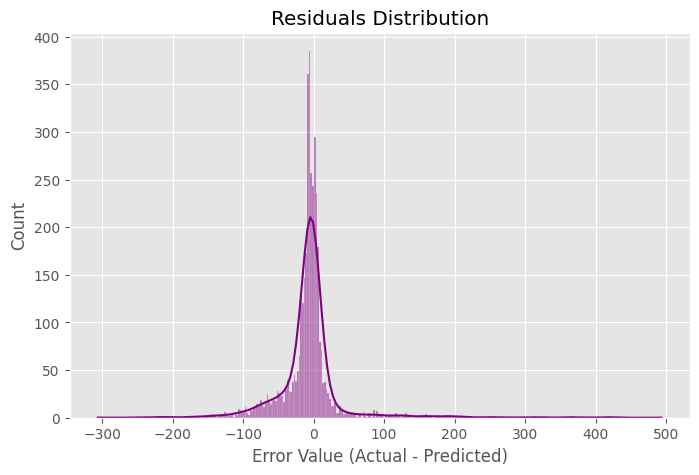

['minmax_scaler_champion.pkl']

In [16]:

# 2. Residuals Analysis
residuals = y_test - xgb_preds
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, color='purple')
plt.title("Residuals Distribution")
plt.xlabel("Error Value (Actual - Predicted)")
plt.show()

# 3. Save the Model and Scaler
joblib.dump(final_model_stable, 'final_xgboost_model_champion.pkl')
joblib.dump(scaler, 'minmax_scaler_champion.pkl')




--- جدول مقارنة أداء النماذج ---

╒═══════════════════╤═══════════════════════╤════════════════════════════╕
│ Model             │ R² Score (Accuracy)   │ MAE (Mean Abs. Error) Wh   │
╞═══════════════════╪═══════════════════════╪════════════════════════════╡
│ XGBoost           │ 0.6637                │ 26.2451                    │
├───────────────────┼───────────────────────┼────────────────────────────┤
│ Linear Regression │ 0.6412                │ 26.8723                    │
├───────────────────┼───────────────────────┼────────────────────────────┤
│ Random Forest     │ 0.5782                │ 28.4456                    │
├───────────────────┼───────────────────────┼────────────────────────────┤
│ SVR               │ 0.4485                │ 33.7356                    │
╘═══════════════════╧═══════════════════════╧════════════════════════════╛


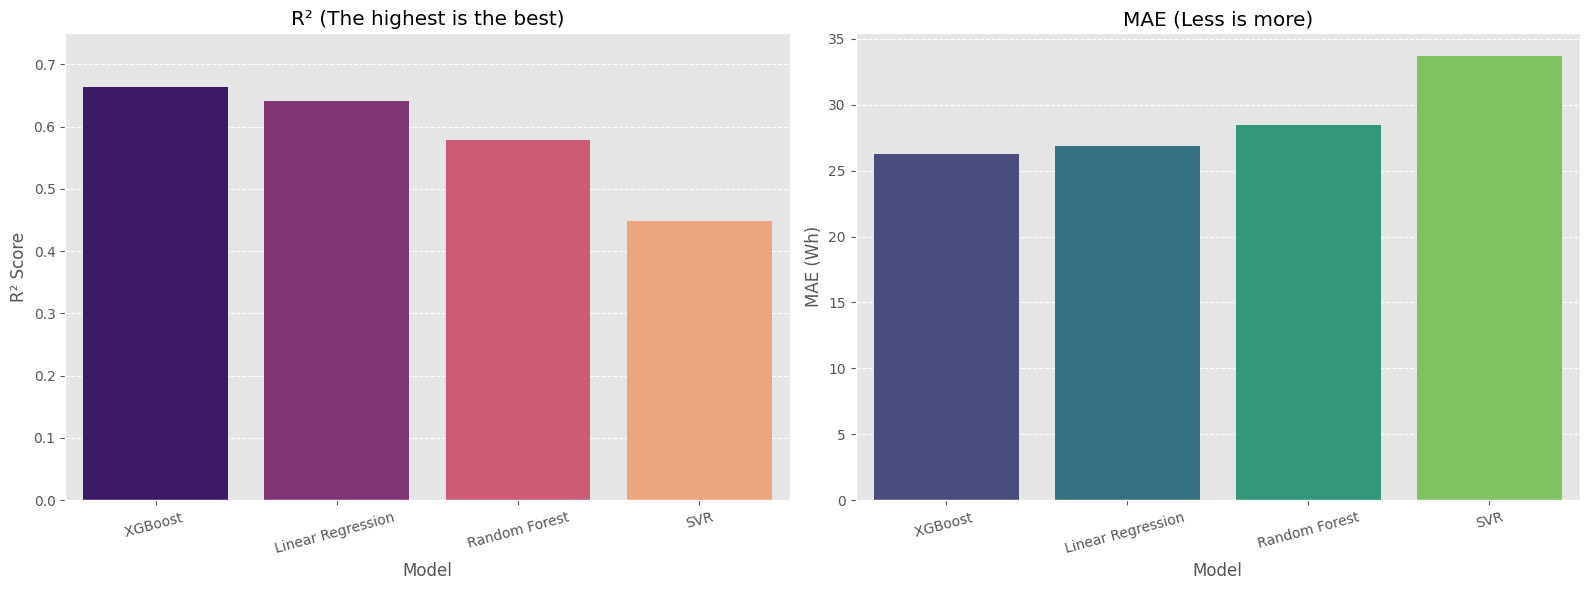

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate


results = {
    'Model': ['XGBoost ','Linear Regression ','Random Forest','SVR'],
    'R² Score (Accuracy)': [0.6637,0.6412 ,0.5782 ,0.4485],
    'MAE (Mean Abs. Error) Wh': [26.2451,26.8723,28.4456,33.7356]
}
df_results = pd.DataFrame(results)

print("\n--- جدول مقارنة أداء النماذج ---\n")

print(tabulate(df_results, headers='keys', tablefmt='fancy_grid', showindex=False, numalign="left"))

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.barplot(
    x='Model',
    y='R² Score (Accuracy)',
    data=df_results.sort_values(by='R² Score (Accuracy)', ascending=False),
    palette='magma'
)
plt.title('R² (The highest is the best)')
plt.ylabel('R² Score')
plt.ylim(0, 0.75)
plt.grid(axis='y', linestyle='--')
plt.xticks(rotation=15)

plt.subplot(1, 2, 2)
sns.barplot(
    x='Model',
    y='MAE (Mean Abs. Error) Wh',
    data=df_results.sort_values(by='MAE (Mean Abs. Error) Wh', ascending=True),
    palette='viridis'
)
plt.title('MAE (Less is more)')
plt.ylabel('MAE (Wh)')
plt.grid(axis='y', linestyle='--')
plt.xticks(rotation=15)

plt.tight_layout()
plt.show()